In [1]:
from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import json
import os

from cell_inference.config import paths, params
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.transform.geometry_transformation import pol2cart, cart2pol
from cell_inference.cells.simulation import Simulation
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.utils.currents.ecp import EcpMod, EcpCell
from cell_inference.utils.spike_window import first_pk_tr, get_spike_window
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

%matplotlib inline

## Load data

In [2]:
DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'neuronal_model_491766131_tuned_Loc5')

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
ranges = config_dict['Simulation_Parameters']['loc_param_range']
ranges.update(config_dict['Simulation_Parameters']['geo_param_range'])

print(inference_list)

['y', 'd', 'theta', 'h', 'phi']


### Transform labels

#### Orientation

In [3]:
check_orient = 'h' in inference_list and 'phi' in inference_list
if check_orient:
    orient_idx0 = [inference_list.index(x) for x in ['h', 'phi']]
    orient_idx2 = orient_idx0.copy()

direction_vec = True # represent orientation by vector on unit sphere
direction_vec = direction_vec and check_orient

label_list = inference_list.copy()
if direction_vec:
    orient_idx1 = list(range(len(inference_list) - 2, len(inference_list) + 1))
    orient_idx2 = [orient_idx1[1], len(inference_list) + 1]
    label_list.remove('h')
    label_list.remove('phi')
    label_list += ['vx', 'vy', 'vz']
    for i in orient_idx1:
        ranges[label_list[i]] = [-1., 1.]

display_list = label_list.copy()
if direction_vec:
    display_list[orient_idx1[1]] = 'vy / h'
    display_list.append('phi')

#### y shift

In [4]:
has_yshift = 'y' in label_list
if has_yshift:
    ys_idx = label_list.index('y')
    label_list[ys_idx] = 'ys'
    display_list[display_list.index('y')] = 'y-shift'

## Select location parameter

In [5]:
loc_param_select = {'y': 0., 'd': 80., 'theta': 0., 'alpha': np.pi/4, 'h': 1., 'phi': 0.} # enter location parameters
loc_param_list = config_dict['Simulation_Parameters']['loc_param_list']

if 'd' in loc_param_select.keys() and 'theta' in loc_param_select.keys():
    loc_param_select['x'], loc_param_select['z'] = pol2cart(loc_param_select['d'], loc_param_select['theta'])
loc_param = np.array([loc_param_select[x] for x in loc_param_list])

## Get ground truth

#### from detailed model

In [6]:
DETAILED_PATH = 'cell_inference/resources/detailed'
model_name = 'neuronal_model_491766131'
file = os.path.join(DETAILED_PATH, model_name + '_Im.h5')

ecp_detailed = EcpMod(EcpCell(file=file), params.ELECTRODE_POSITION, move_cell=loc_param.reshape((2, 3)), min_distance=10.0)

detailed_lfp = ecp_detailed.calc_ecp().T

#### from stylized model

In [7]:
h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD_OBLIQUE, index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

# Biophysical parameters
filepath = './cell_inference/resources/biophys_parameters/'+model_name+'.json'
with open(filepath) as f:
    full_biophys = json.load(f)

# common parameters
biophys_param = [200, 50, 120] # Ra: basal, trunk, tuft
biophys_comm = {}

# geometry parameters
geo_param = [config_dict['Simulation_Parameters']['geo_param_default'][x] for x in config_dict['Simulation_Parameters']['geo_param_list']]

# Fixed gmax, not using gmax mapping file
gmax = 0.02

# stimulus parameter
stim_param = {'start': 2.}

sim = Simulation(geometry = geo_standard,
                 full_biophys = full_biophys,
                 electrodes = params.ELECTRODE_POSITION,
                 cell_type = CellTypes.ACTIVE_FULL,
                 biophys = biophys_param,
                 biophys_comm = biophys_comm,
                 loc_param = loc_param,
                 geo_param = geo_param,
                 spike_threshold = -30,
                 gmax = gmax,
                 stim_param = stim_param,
                 scale = 1.,
                 ncell = 1)

sim.run_neuron_sim()

start_idx = int(np.ceil(stim_param['start']/h.dt)) # ignore signal before
stylized_lfp = sim.get_lfp().T[start_idx:,:]

In [8]:
lfp = [detailed_lfp, stylized_lfp]

## Get LFP

In [9]:
filt_b, filt_a = signal.butter(params.BUTTERWORTH_ORDER,
                               params.FILTER_CRITICAL_FREQUENCY,
                               params.BANDFILTER_TYPE,
                               fs=params.FILTER_SAMPLING_RATE)

filtered_lfp = [signal.lfilter(filt_b, filt_a, x, axis=0) for x in lfp]  # filter along time axis

pk_tr_idx_in_window = 24  # 24*0.025=0.6 ms
lfp_list = []
bad_indices = []
for i in range(len(lfp)):
#     filtered_lfp[i] /= np.max(np.abs(filtered_lfp[i]))
    try:
        start, end = get_spike_window(filtered_lfp[i], win_size=params.WINDOW_SIZE, align_at=pk_tr_idx_in_window)
        lfp_list.append(filtered_lfp[i][start:end,:])
    except ValueError:
        bad_indices.append(i)

t = sim.t()[:params.WINDOW_SIZE]
windowed_lfp = np.stack(lfp_list, axis=0)  # (samples x time window x channels)
print('%d bad samples.' % len(bad_indices))

y_idx = loc_param_list.index('y') if 'y' in inference_list else None
summ_stats = []
data = []
coordinates = []
bad_indices = []
yshift = []
for i in range(windowed_lfp.shape[0]):
    try:
        g_lfp, g_coords, y_c = build_lfp_grid(windowed_lfp[i], params.ELECTRODE_POSITION[:, :2], y_window_size=960.0)
    except ValueError:
        bad_indices.append(i)
        continue
    summ_stats.append(calculate_stats(g_lfp))
    data.append(g_lfp)
    coordinates.append(g_coords)
    if y_idx is not None:
        yshift.append(y_c - loc_param[y_idx])

summ_stats = np.array(summ_stats)
yshift = np.array(yshift)
print('%d bad samples.' % len(bad_indices))

0 bad samples.
0 bad samples.


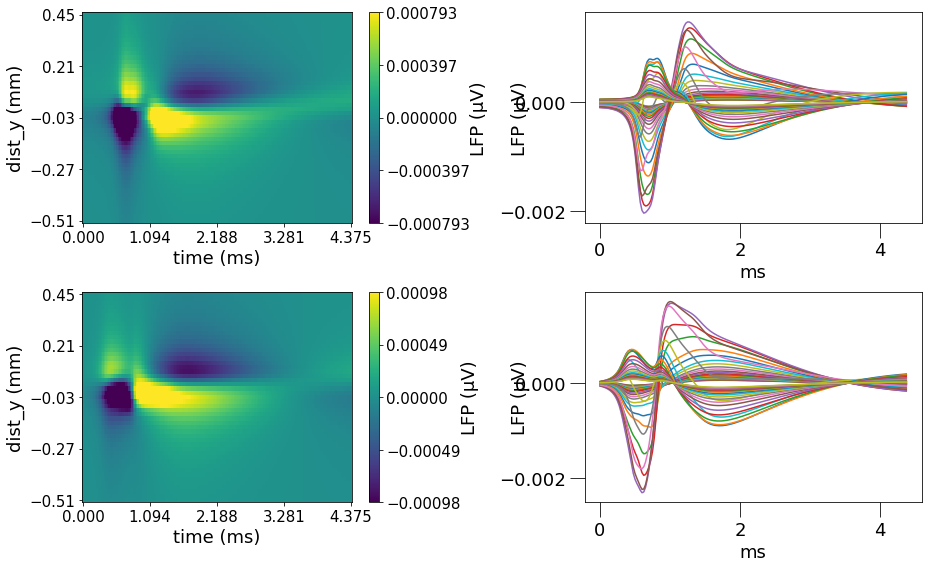

In [19]:
ix = 1
ylim = [-1900,1900]
x_dist = np.unique(g_coords[:,0])
e_idx = ((g_coords[:,0]==x_dist[ix]) &
         (g_coords[:,1]>=ylim[0]) &
         (g_coords[:,1]<=ylim[1]))

nlfp = len(lfp)
plt.figure(figsize=(13, 4 * nlfp))
for j, d in enumerate(data):
    ax = plt.subplot(nlfp, 2, 2*j+1)
    _ = plot_lfp_heatmap(t=t,
                         elec_d=coordinates[j][e_idx, 1],
                         lfp=d[:,e_idx],
                         vlim='auto',
                         fontsize=18, labelpad=0, ticksize=15, nbins=5,
                         axes = ax
                        )
    ax = plt.subplot(nlfp, 2, 2*j+2)
    _ = plot_lfp_traces(t, d[:,e_idx], fontsize=18, axes = ax)
plt.tight_layout()
plt.show()